<a href="https://colab.research.google.com/github/Bpriya42/bias-reduction-facial-recognition/blob/main/racial_constraints_for_Age.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Data Prep


In [ ]:
!pip install datasets

In [ ]:
! pip install --upgrade seldonian-engine

In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import necessary libraries
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
import pandas as pd
from PIL import Image
import io
from seldonian.utils.io_utils import save_pickle

# Check PyTorch and torchvision versions
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

# Load the FairFace dataset
def load_fair_dataset_combined():
    ds = load_dataset("HuggingFaceM4/FairFace", "0.25")
    df_train = ds['train'].to_pandas()
    df_test = ds['validation'].to_pandas()
    combined_df = pd.concat([df_train, df_test], ignore_index=True)
    return df_train.iloc[:, 0:4], df_test.iloc[:, 0:4], combined_df.iloc[:, 0:4]

df_train, df_test, combined_df = load_fair_dataset_combined()

# Shuffle and sample train and test datasets
data_train = df_train.sample(n=len(df_train), random_state=42).iloc[:len(df_train)]
data_test = df_test.sample(n=len(df_test), random_state=42).iloc[:len(df_test)]

# Function to process images
def process_rgb_image(image_dict):
    try:
        image_bytes = image_dict['bytes']
        image = Image.open(io.BytesIO(image_bytes))
        image = image.convert("RGB")  # Ensure 3 channels
        image = image.resize((48, 48))  # Resize to (48, 48)
        image_array = np.array(image, dtype=np.float32) / 255.0  # Normalize to [0, 1]
        return image_array
    except Exception as e:
        print(f"Error processing image: {e}")
        return None

# Process images for train and test datasets
print("Processing RGB images...")
data_train['pixels'] = data_train['image'].apply(process_rgb_image)
data_test['pixels'] = data_test['image'].apply(process_rgb_image)
combined = pd.concat([data_train, data_test], ignore_index=True)

# Convert images to NumPy arrays
X = np.array(combined['pixels'].tolist()).reshape(-1, 3, 48, 48)  # Reshape to (num_samples, 3, 48, 48)
# labels = combined['age'].values  # Gender labels

images =  X.reshape(X.shape[0], 3, 48, 48)

PyTorch version: 2.5.1+cu121
torchvision version: 0.20.1+cu121
Processing RGB images...


#### Labeled as 0 and 1

In [ ]:
# Partition age into two groups based on the median age - 0 and 1
def partition_age(data):
    if 'age' not in data.columns:
        raise KeyError("The 'age' column is missing from the DataFrame.")
    median_age = data['age'].median()
    data['age_group'] = (data['age'] > median_age).astype(int)

    print(f"Median age: {median_age}")
    print("Partitioned Data:")
    print(data[['age', 'age_group']].head())  # Debugging output
    return data

# Apply the function with balanced threshold (based on median age)
combined = partition_age(combined)

# Verify the partitioned data
print("Age group distribution in combined dataset after median split:")
print(combined['age_group'].value_counts())


Median age: 3.0
Partitioned Data:
   age  age_group
0    3          0
1    4          1
2    2          0
3    4          1
4    2          0
Age group distribution in combined dataset after median split:
age_group
0    52937
1    44761
Name: count, dtype: int64


Unique races: [4 1 2 5 0 3 6]
Unique ages: [3 4 2 1 6 8 5 0 7]


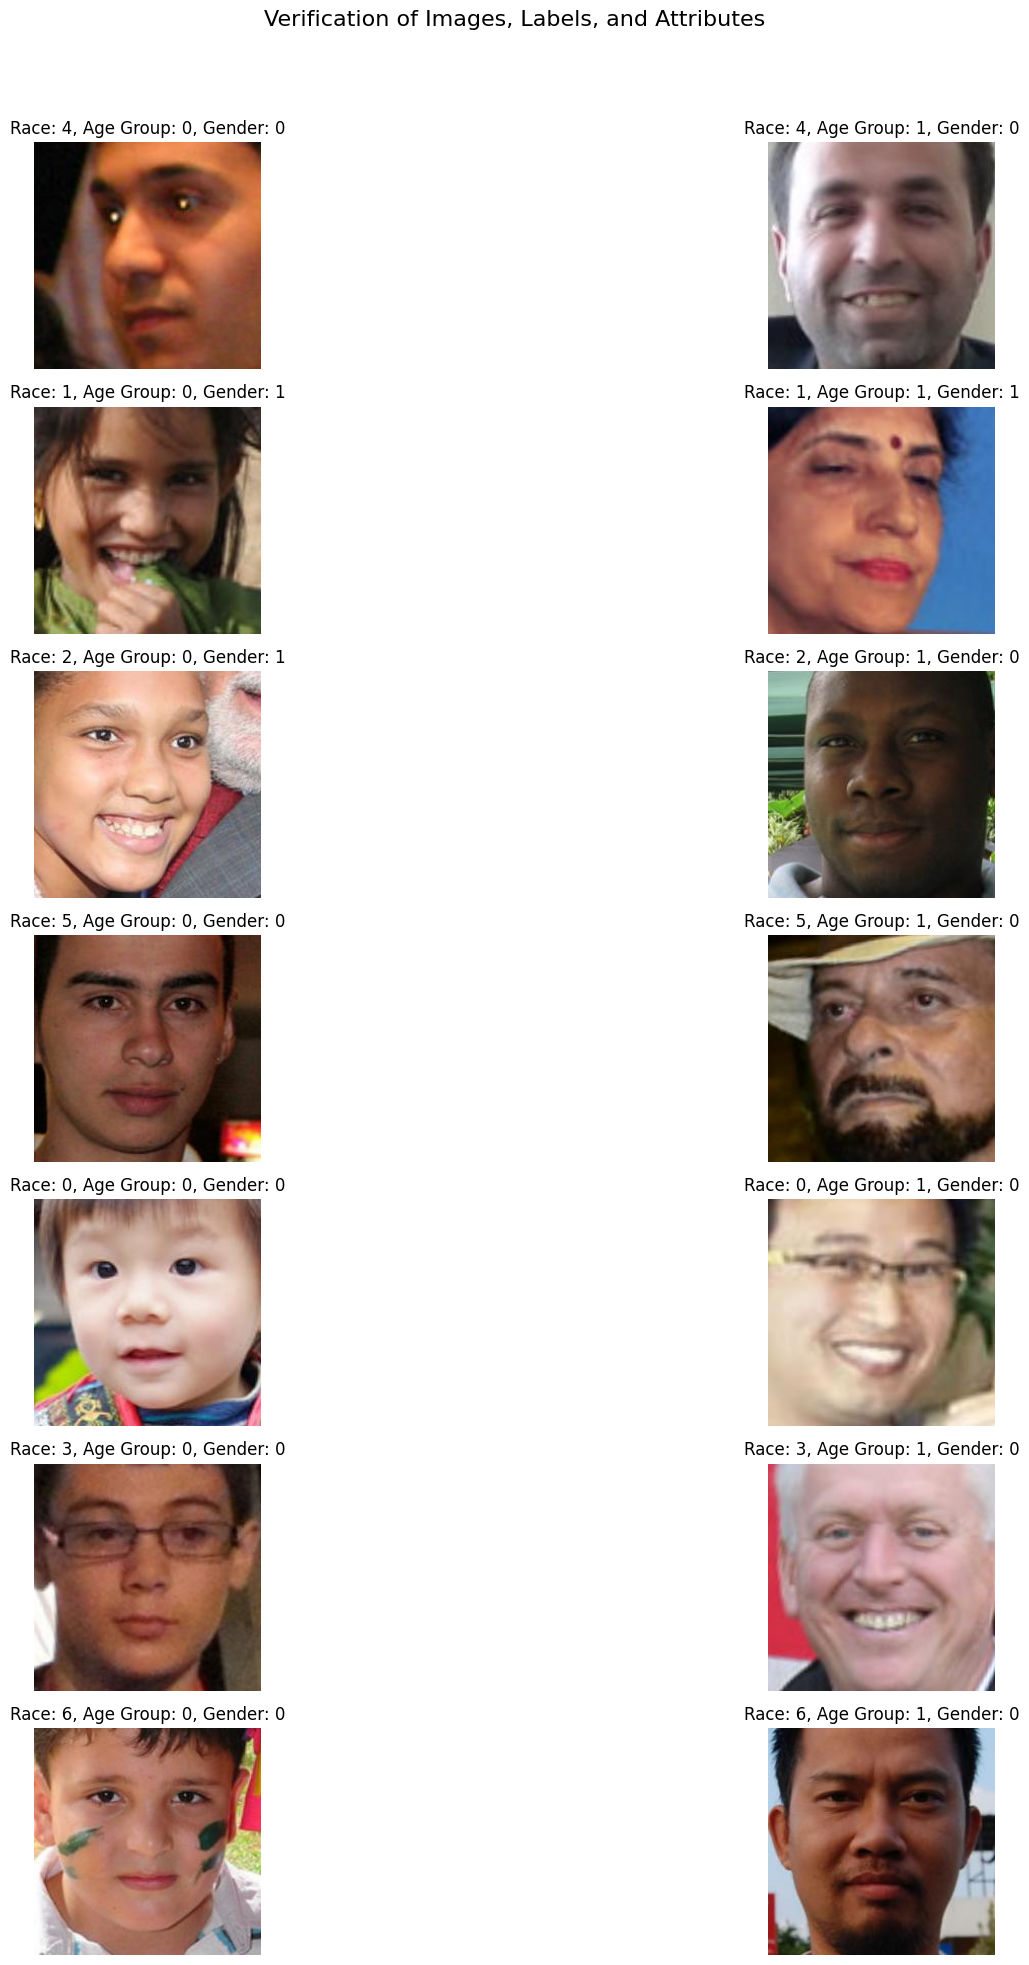

In [ ]:
# Verify the processed data for 0 and 1
def verify_data(data):
    unique_races = data['race'].unique()
    unique_ages = data['age'].unique()
    print("Unique races:", unique_races)
    print("Unique ages:", unique_ages)

    fig, axes = plt.subplots(len(unique_races), 2, figsize=(20, 20))
    fig.suptitle("Verification of Images, Labels, and Attributes", fontsize=16)

    for i, race in enumerate(unique_races):
        for j, age_group in enumerate([0, 1]):
            filtered_data = data[(data['race'] == race) & (data['age_group'] == age_group)]
            if not filtered_data.empty:
                sample = filtered_data.iloc[0]
                image_bytes = sample['image']['bytes']
                image = Image.open(io.BytesIO(image_bytes))

                ax = axes[i, j]
                ax.imshow(image)
                ax.axis('off')
                gender = sample['gender']
                ax.set_title(f"Race: {race}, Age Group: {age_group}, Gender: {gender}")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

verify_data(combined)

#### Labeled as Young and Old

In [ ]:
# # Partition age into two groups based on the median age
# def partition_age(data):
#     if 'age' not in data.columns:
#         raise KeyError("The 'age' column is missing from the DataFrame.")

#     # Get the median age for splitting
#     median_age = data['age'].median()

#     # Create a new 'age_group' column where 0 = young, 1 = old
#     data['age_group'] = (data['age'] > median_age).astype(int)

#     # Map 0 to 'young' and 1 to 'old'
#     data['age_group'] = data['age_group'].replace({0: 'young', 1: 'old'})

#     print(f"Median age: {median_age}")
#     print("Partitioned Data:")
#     print(data[['age', 'age_group']].head())  # Debugging output
#     return data

# # Apply the function with balanced threshold (based on median age)
# combined = partition_age(combined)

# # Verify the partitioned data
# print("Age group distribution in combined dataset after median split:")
# print(combined['age_group'].value_counts())

In [ ]:
# import matplotlib.pyplot as plt
# from PIL import Image
# import io

# # Verify the processed data
# def verify_data(data):
#     unique_races = data['race'].unique()
#     unique_age_groups = data['age_group'].unique()  # This will now be 'young' and 'old'
#     print("Unique races:", unique_races)
#     print("Unique age groups:", unique_age_groups)

#     fig, axes = plt.subplots(len(unique_races), len(unique_age_groups), figsize=(20, 20))
#     fig.suptitle("Verification of Images, Labels, and Attributes", fontsize=16)

#     for i, race in enumerate(unique_races):
#         for j, age_group in enumerate(unique_age_groups):
#             filtered_data = data[(data['race'] == race) & (data['age_group'] == age_group)]
#             if not filtered_data.empty:
#                 sample = filtered_data.iloc[0]
#                 image_bytes = sample['image']['bytes']
#                 image = Image.open(io.BytesIO(image_bytes))

#                 ax = axes[i, j]
#                 ax.imshow(image)
#                 ax.axis('off')
#                 gender = sample['gender']
#                 ax.set_title(f"Race: {race}, Age Group: {age_group}, Gender: {gender}")

#     plt.tight_layout(rect=[0, 0, 1, 0.95])
#     plt.show()

# # Apply verification to the data
# verify_data(combined)


In [ ]:
# View samples from age group 0
print("Samples from age group 0:")
print(combined[combined['age_group'] == 0].head())

# View samples from age group 1
print("\nSamples from age group 1:")
print(combined[combined['age_group'] == 1].head())


Samples from age group 0:
                                               image  age  gender  race  \
0  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    3       0     4   
2  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    2       1     1   
4  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    2       0     1   
5  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    3       0     5   
6  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    1       0     0   

                                              pixels  age_group  
0  [[[0.023529412, 0.023529412, 0.023529412], [0....          0  
2  [[[0.20784314, 0.18431373, 0.17254902], [0.207...          0  
4  [[[0.40784314, 0.3372549, 0.28235295], [0.4784...          0  
5  [[[0.105882354, 0.047058824, 0.023529412], [0....          0  
6  [[[0.2509804, 0.21176471, 0.21960784], [0.3333...          0  

Samples from age group 1:
                                                image  age  gender  race  \
1   {'bytes': b'\xff\xd8

In [ ]:
# # One-hot encode the 'race' column
# combined['caucasian'] = (combined['race'] == 3).astype(int)  # 1 if race is 3, else 0
# combined['not_caucasian'] = (combined['race'] != 3).astype(int)  # 1 if race is 5, else 0

# race_three = combined['caucasian'].values
# race_five = combined['not_caucasian'].values

# sensitive_attrs = np.hstack((race_three.reshape(-1,1),race_five.reshape(-1,1)))

## Encoding

In [ ]:

import numpy as np

# Modify labels to be age_group
labels = np.array(combined['age_group'])  # Explicit conversion to numpy array

# # Modify labels to be age_group
# labels = combined['age_group'].values  # age_group labels


# One-hot encode 'race' and 'gender' columns for sensitive attributes
combined['male'] = (combined['gender'] == 0).astype(int)  # 1 if gender is male, else 0
combined['female'] = (combined['gender'] == 1).astype(int)  # 1 if gender is female, else 0
combined['caucasian'] = (combined['race'] == 3).astype(int)  # 1 if race is 3 (Caucasian), else 0
combined['not_caucasian'] = (combined['race'] != 3).astype(int)  # 1 if race is not Caucasian, else 0

# # Combine the sensitive attributes (race and gender)
# sensitive_attrs = np.hstack((
#     combined[['male', 'female']].values,  # gender attributes
#     combined[['caucasian', 'not_caucasian']].values  # race attributes
# ))
# Assuming you've already created the one-hot encoded columns for gender and race
# sensitive_attrs = combined[['male', 'female', 'caucasian', 'not_caucasian']].values


# Sensitive attributes
sensitive_attrs = np.hstack((
    combined[['male', 'female']].values,  # gender attributes
    combined[['caucasian', 'not_caucasian']].values  # race attributes
))

# Define sensitive column names to match the attributes created above
sensitive_col_names = ['male', 'female', 'caucasian', 'not_caucasian']


# Save the processed data
savename_features = '/content/drive/MyDrive/682_Project/features_age.pkl'
savename_labels = '/content/drive/MyDrive/682_Project/labels_age.pkl'
savename_sensitive_attrs = '/content/drive/MyDrive/682_Project/sensitive_attrs_age.pkl'

print("Saving features and labels...")
save_pickle(savename_features, X)  # features are the image data
save_pickle(savename_labels, labels)  # labels are now age_group
save_pickle(savename_sensitive_attrs, sensitive_attrs)  # sensitive attributes are race and gender

print("Processing complete.")


Saving features and labels...
Processing complete.


##Models



### ResNet50




In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

class AgeGroupClassificationResNet50:
    def __init__(self, device, num_classes=2, lr=0.01, momentum=0.9):
        """
        Age group classification using ResNet50 pre-trained model.

        :param device: Device for training (cuda or cpu)
        :param num_classes: Number of classes for classification (2 for age group: 0 or 1)
        :param lr: Learning rate for the optimizer
        :param momentum: Momentum for the SGD optimizer
        """
        self.device = device
        self.num_classes = num_classes
        self.model = self.load_pretrained_resnet50(num_classes)
        self.model.to(self.device)

        # Optimizer and loss function setup
        self.optimizer = optim.SGD(self.model.parameters(), lr=lr, momentum=momentum)
        self.loss_criterion = nn.CrossEntropyLoss()

        self.model_name = 'ResNet50'

    def load_pretrained_resnet50(self, num_classes):
        """
        Load the pre-trained ResNet50 model and modify the last layer.

        :param num_classes: Number of output classes (2 for age groups)
        :return: Modified ResNet50 model
        """
        model = models.resnet50(weights="DEFAULT")  # Load weights from pre-trained model
        model.fc = nn.Linear(in_features=model.fc.in_features, out_features=num_classes)
        return model

    def train(self, train_data, train_labels, epochs=10, batch_size=64):
        """
        Train the model on the provided dataset.

        :param train_data: Training data (tensor of shape (N, 3, H, W))
        :param train_labels: Training labels (tensor of shape (N,))
        :param epochs: Number of epochs for training
        :param batch_size: Batch size for training
        """
        self.model.train()
        dataset = torch.utils.data.TensorDataset(train_data, train_labels)
        data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

        for epoch in range(epochs):
            epoch_loss = 0.0
            for batch_features, batch_labels in data_loader:
                batch_features, batch_labels = batch_features.to(self.device), batch_labels.to(self.device)

                self.optimizer.zero_grad()
                predictions = self.model(batch_features)
                loss = self.loss_criterion(predictions, batch_labels)
                loss.backward()
                self.optimizer.step()

                epoch_loss += loss.item()
            print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(data_loader)}")

    def predict(self, test_data):
        """
        Predict the labels for the given test data.

        :param test_data: Test data (tensor of shape (N, 3, H, W))
        :return: Predicted labels (tensor of shape (N,))
        """
        self.model.eval()
        with torch.no_grad():
            predictions = self.model(test_data.to(self.device))
        return predictions.argmax(dim=1).cpu().numpy()

    def save_model(self, path):
        """
        Save the model to the specified path.

        :param path: Path to save the model
        """
        torch.save(self.model.state_dict(), path)

    def load_model(self, path):
        """
        Load the model weights from the specified path.

        :param path: Path to the saved model
        """
        self.model.load_state_dict(torch.load(path))
        self.model.to(self.device)

### VGGFaceNet16

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

class AgeGroupClassificationVGG16:
    def __init__(self, device, num_classes=2, lr=0.01, momentum=0.9):
        """
        Age group classification using VGG-16 pre-trained model.

        :param device: Device for training (cuda or cpu)
        :param num_classes: Number of classes for classification (2 for age group)
        :param lr: Learning rate for the optimizer
        :param momentum: Momentum for the SGD optimizer
        """
        self.device = device
        self.num_classes = num_classes
        self.model = self.load_pretrained_vgg16(num_classes)
        self.model.to(self.device)

        # Optimizer and loss function setup
        self.optimizer = optim.SGD(self.model.parameters(), lr=lr, momentum=momentum)
        self.loss_criterion = nn.CrossEntropyLoss()

        self.model_name = 'VGG16_AgeGroup'

    def load_pretrained_vgg16(self, num_classes):
        """
        Load the pre-trained VGG-16 model and modify the last layer.

        :param num_classes: Number of output classes (2 for age groups)
        :return: Modified VGG-16 model
        """
        model = models.vgg16(weights="DEFAULT")  # Load weights from pre-trained model
        model.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)  # Modify final layer
        return model

    def train(self, train_data, train_labels, epochs=10, batch_size=64):
        """
        Train the model on the provided dataset.

        :param train_data: Training data (tensor of shape (N, 3, H, W))
        :param train_labels: Training labels (tensor of shape (N,))
        :param epochs: Number of epochs for training
        :param batch_size: Batch size for training
        """
        self.model.train()
        dataset = torch.utils.data.TensorDataset(train_data, train_labels)
        data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

        for epoch in range(epochs):
            epoch_loss = 0.0
            for batch_features, batch_labels in data_loader:
                batch_features, batch_labels = batch_features.to(self.device), batch_labels.to(self.device)

                self.optimizer.zero_grad()
                predictions = self.model(batch_features)
                loss = self.loss_criterion(predictions, batch_labels)
                loss.backward()
                self.optimizer.step()

                epoch_loss += loss.item()
            print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(data_loader)}")

    def predict(self, test_data):
        """
        Predict the labels for the given test data.

        :param test_data: Test data (tensor of shape (N, 3, H, W))
        :return: Predicted labels (tensor of shape (N,))
        """
        self.model.eval()
        with torch.no_grad():
            predictions = self.model(test_data.to(self.device))
        return predictions.argmax(dim=1).cpu().numpy()

    def save_model(self, path):
        """
        Save the model to the specified path.

        :param path: Path to save the model
        """
        torch.save(self.model.state_dict(), path)

    def load_model(self, path):
        """
        Load the model weights from the specified path.

        :param path: Path to the saved model
        """
        self.model.load_state_dict(torch.load(path))
        self.model.to(self.device)


### Seldonian Model - CNN

In [ ]:
from seldonian.models.pytorch_model import SupervisedPytorchBaseModel
import torch.nn as nn
import torch

class FacialRecogCNNModel(nn.Module):
    def __init__(self):
        super(FacialRecogCNNModel, self).__init__()
        # Define all layers here
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.cnn3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.cnn4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)

        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)

        self.Batch1 = nn.BatchNorm2d(16)
        self.Batch2 = nn.BatchNorm2d(32)
        self.Batch3 = nn.BatchNorm2d(64)
        self.Batch4 = nn.BatchNorm2d(128)

        # Fully connected layers (readout)
        self.fc1 = nn.Linear(128 * 1 * 1, 128)  # Adjust for flattened output
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 2)  # Output layer with 2 units for binary classification
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Call all layers here. This does the forward pass.
        out = self.cnn1(x)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.Batch1(out)

        out = self.cnn2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.Batch2(out)

        out = self.cnn3(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.Batch3(out)

        out = self.cnn4(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.Batch4(out)

        # Resize the output to flatten for the fully connected layers
        out = torch.flatten(out, start_dim=1)

        # Linear functions (readout)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)

        # Softmax to make probabilities for the two age groups (0: young, 1: old)
        out = self.softmax(out)[:, 1]  # Only return the probability of age group 1 (old)

        return out

class PytorchFacialRecog(SupervisedPytorchBaseModel):
    def __init__(self, device):
        """ Implements a CNN with PyTorch for age group classification.
        CNN consists of four hidden layers followed
        by a linear + softmax output layer for binary classification (young vs old).
        """
        super().__init__(device)

    def create_model(self, **kwargs):
        """ Create the pytorch model and return it
        """
        return FacialRecogCNNModel()


In [ ]:
# Define parameters
device = 'cuda'  # or 'cuda' if using a GPU
num_classes = 2  # 2 age categories

# Instantiate the model
model_cnn = PytorchFacialRecog(device=device)

# Create the CNN model
cnn_model = model_cnn.create_model()

# Print model architecture
print(cnn_model)

FacialRecogCNNModel(
  (cnn1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cnn2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (cnn3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (cnn4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Batch1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Batch3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Batch4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)


In [ ]:
!apt-get install git
!git clone https://github.com/seldonian-toolkit/Engine.git "/content/drive/My Drive/ColabNotebooks/682_project/seldonian_toolkit"


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.11).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
fatal: destination path '/content/drive/My Drive/ColabNotebooks/682_project/seldonian_toolkit' already exists and is not an empty directory.


### Running the Seldonian Experiment - adding specs and constraints.

In [ ]:
from seldonian.spec import SupervisedSpec
from seldonian.dataset import SupervisedDataSet
from seldonian.utils.io_utils import load_pickle,save_pickle
from seldonian.models import objectives
from seldonian.seldonian_algorithm import SeldonianAlgorithm
from seldonian.parse_tree.parse_tree import (
    make_parse_trees_from_constraints)
import autograd.numpy as np
from types import SimpleNamespace

In [ ]:
regime = 'supervised_learning'
sub_regime = 'classification'

images =  X.reshape(X.shape[0], 3, 48, 48)
# Use the correct features, labels, and sensitive attributes
features = images  # Assuming 'images' is the feature data, no changes needed here
# labels = combined['age_group']  # 'age_group' instead of 'gender'
labels = np.array(combined['age_group'])
# sensitive_attrs = combined[['race_three', 'race_other']]  # Or other sensitive attributes as needed
# Assuming you've already created the one-hot encoded columns for gender and race
# sensitive_attrs = combined[['male', 'female', 'caucasian', 'not_caucasian']].values

# # Define the fraction of data in safety and sensitive column names (including age)
frac_data_in_safety = 0.5
# # sensitive_col_names = ['race_three', 'race_other', 'age_group']  # Add 'age_group' as a sensitive attribute if applicable
# sensitive_col_names = ['male', 'female', 'caucasian', 'not_caucasian']
# # Meta information for dataset
# meta_information = SimpleNamespace(
#     feature_col_names=['image'],
#     label_col_names=['age_group'],  # Change 'gender' to 'age_group'
#     sensitive_col_names=sensitive_col_names,
#     sub_regime=sub_regime,
#     regime=regime
# )


# # Define fairness constraints for the dataset
# # Define the fairness constraints for the dataset
# constraint_strs = [
#     # Race fairness constraint
#      'min((ACC | [caucasian])/(ACC | [not_caucasian]), (ACC | [not_caucasian])/(ACC | [caucasian])) >= 0.8' ]#,

#     # # Gender fairness constraint
#     # 'min((ACC | [male])/(ACC | [female]), (ACC | [female])/(ACC | [male])) >= 0.8'


# # Define corresponding deltas for each constraint (must match the length of constraint_strs)
# deltas = [0.05]  # Two constraints, so two delta values

# print("Making parse trees for constraint(s):")
# print(constraint_strs, "with deltas:", deltas)

# # Now, the length of deltas matches the length of constraint_strs
# parse_trees = make_parse_trees_from_constraints(
#     constraint_strs, deltas, regime=regime,
#     sub_regime=sub_regime, columns=sensitive_col_names
# )

# Assuming you've already created the one-hot encoded columns for race
sensitive_attrs = combined[['caucasian', 'not_caucasian']].values  # Only race-related attributes

# Update sensitive column names to only include race-related columns
sensitive_col_names = ['caucasian', 'not_caucasian']

# Meta information for dataset
meta_information = SimpleNamespace(
    feature_col_names=['image'],
    label_col_names=['age_group'],  # Change 'gender' to 'age_group'
    sensitive_col_names=sensitive_col_names,
    sub_regime=sub_regime,
    regime=regime
)

print("Making SupervisedDataSet...")
dataset = SupervisedDataSet(
    features=features,
    labels=labels,
    sensitive_attrs=sensitive_attrs,
    num_datapoints=len(features),
    meta=meta_information
)


# Define fairness constraints for race
constraint_strs = [
    'min((ACC | [caucasian])/(ACC | [not_caucasian]), (ACC | [not_caucasian])/(ACC | [caucasian])) >= 0.8'
]

# Define corresponding deltas for each constraint (must match the length of constraint_strs)
deltas = [0.05]

print("Making parse trees for constraint(s):")
print(constraint_strs, "with deltas:", deltas)

# Now, the length of deltas matches the length of constraint_strs
parse_trees = make_parse_trees_from_constraints(
    constraint_strs, deltas, regime=regime,
    sub_regime=sub_regime, columns=sensitive_col_names
)

# Define the objective function for binary logistic loss (for age classification)
initial_solution_fn = model_cnn.get_model_params

primary_objective_fn = objectives.binary_logistic_loss  # Ensure you're using binary logistic loss for age classification

Making SupervisedDataSet...
Making parse trees for constraint(s):
['min((ACC | [caucasian])/(ACC | [not_caucasian]), (ACC | [not_caucasian])/(ACC | [caucasian])) >= 0.8'] with deltas: [0.05]


In [ ]:
spec = SupervisedSpec(
    dataset=dataset,  # Ensure dataset is correctly created with features, labels, and sensitive attributes
    model=model_cnn,  # Ensure model is defined correctly (e.g., model_cnn)
    parse_trees=parse_trees,  # Fairness constraints (already defined)
    frac_data_in_safety=frac_data_in_safety,
    primary_objective=primary_objective_fn,  # Ensure the correct objective function is used (binary logistic loss)
    use_builtin_primary_gradient_fn=False,  # Set to False if using custom gradient functions
    sub_regime=sub_regime,  # Classification problem
    initial_solution_fn=initial_solution_fn,  # Ensure initial model parameters are correctly defined
    optimization_technique='gradient_descent',  # You may choose a different technique
    optimizer='adam',  # Adam optimizer (this is appropriate for most deep learning tasks)
    optimization_hyperparams={
        'lambda_init'   : np.array([0.5]),  # Regularization parameter
        'alpha_theta'   : 0.001,  # Learning rate for model parameters
        'alpha_lamb'    : 0.001,  # Learning rate for regularization terms
        'beta_velocity' : 0.9,  # Momentum term for gradient descent
        'beta_rmsprop'  : 0.95,  # RMSProp parameter for adaptive learning rates
        'use_batches'   : True,  # Use batches in training
        'batch_size'    : 237,  # Batch size (ensure it's suitable for your dataset)
        'n_epochs'      : 10,  # Number of epochs for training
        'gradient_library': "autograd",  # Gradient computation library (can be autograd or others)
        'hyper_search'  : None,  # Hyperparameter search can be defined if needed
        'verbose'       : True,  # Print verbose logs during training
    },
    batch_size_safety=2000  # Ensure this is set appropriately based on your dataset
)

# Save the spec for later use
save_pickle('./spec.pkl', spec, verbose=True)


Saved ./spec.pkl



moment of truth

In [ ]:
SA = SeldonianAlgorithm(spec)
passed_safety,solution = SA.run(debug=True,write_cs_logfile=True)

if passed_safety:
    print("Passed safety test.")
else:
    print("Failed safety test")

Streaming output truncated to the last 5000 lines.
 -0.02949066] [0.45760786]

epoch,batch_i,overall_i,f,g,theta,lambda: 2 46 460 0.6679135179343606 [-0.12595181] [ 0.1088092   0.02905169  0.12297913 ... -0.0299077   0.0600539
 -0.0294846 ] [0.45750569]

epoch,batch_i,overall_i,f,g,theta,lambda: 2 47 461 0.71100935805196 [-0.18177186] [ 0.10883307  0.02913604  0.12306127 ... -0.02993341  0.06004022
 -0.02947092] [0.45737974]

epoch,batch_i,overall_i,f,g,theta,lambda: 2 48 462 0.7061758971918485 [-0.15310757] [ 0.10887822  0.0292405   0.12314842 ... -0.02988764  0.0600356
 -0.0294663 ] [0.45719796]

epoch,batch_i,overall_i,f,g,theta,lambda: 2 49 463 0.6655160701098825 [-0.16867823] [ 0.10887443  0.02928932  0.12323371 ... -0.02980923  0.06001866
 -0.02944936] [0.45704486]

Epoch: 2, batch iteration 50
epoch,batch_i,overall_i,f,g,theta,lambda: 2 50 464 0.6597810620874293 [-0.13425897] [ 0.10881751  0.02927775  0.1232798  ... -0.0296377   0.05999754
 -0.02942824] [0.45687618]

epoch,batch

## Evaluation


In [ ]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
!git clone https://github.com/seldonian-toolkit/Experiments.git

fatal: destination path 'Experiments' already exists and is not an empty directory.


In [ ]:
!pip install -r /content/drive/MyDrive/Experiments/requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.5/177.5 kB 9.5 MB/s eta 0:00:00


In [ ]:
!python -m experiments.experiment_utils
!python -m experiments.generate_plots
!python -m experiments.baselines.random_classifiers
!python -m experiments.baselines.facial_recog_cnn

# First, navigate to the directory containing the 'experiments' package
%cd /content/drive/MyDrive/Experiments/

# Then install the package
!pip install -e .

# Now, run the rest of the script
import os, math
import numpy as np
import torch

from experiments.generate_plots import SupervisedPlotGenerator
from seldonian.utils.io_utils import load_pickle

#... (rest of the code)

/usr/bin/python3: Error while finding module specification for 'experiments.experiment_utils' (ModuleNotFoundError: No module named 'experiments')
/usr/bin/python3: Error while finding module specification for 'experiments.generate_plots' (ModuleNotFoundError: No module named 'experiments')
/usr/bin/python3: Error while finding module specification for 'experiments.baselines.random_classifiers' (ModuleNotFoundError: No module named 'experiments')
/usr/bin/python3: Error while finding module specification for 'experiments.baselines.facial_recog_cnn' (ModuleNotFoundError: No module named 'experiments')
/content/drive/MyDrive/Experiments
Obtaining file:///content/drive/MyDrive/Experiments
  Preparing metadata (setup.py) ... done
  Running setup.py develop for seldonian_experiments


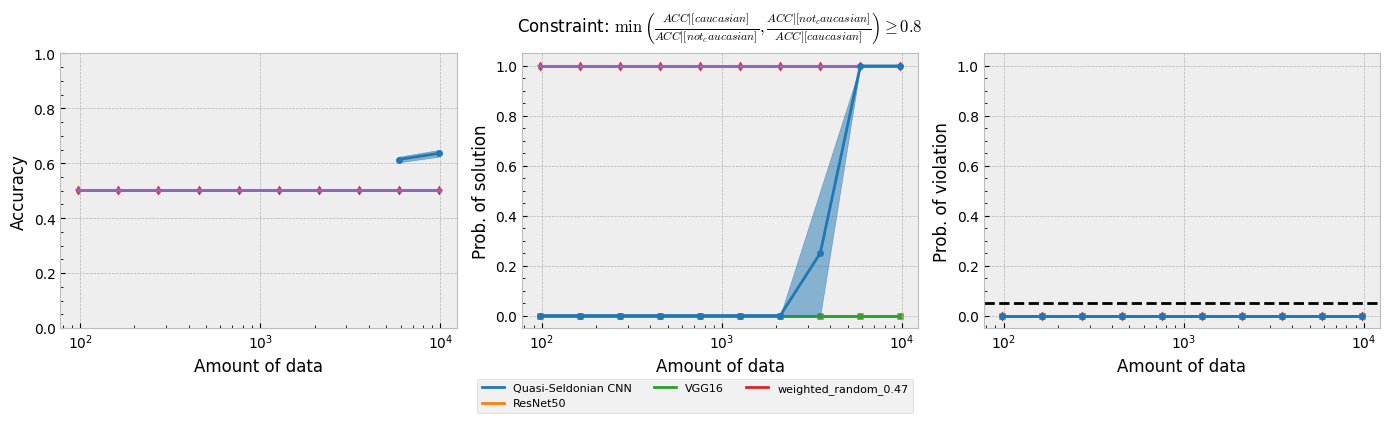

In [ ]:
import os, math
import numpy as np
import torch
from seldonian.models.pytorch_model import SupervisedPytorchBaseModel
import torch.nn as nn
import torch

from experiments.generate_plots import SupervisedPlotGenerator
from seldonian.utils.io_utils import load_pickle

from experiments.baselines.random_classifiers import (
    WeightedRandomClassifierBaseline)
from experiments.baselines.facial_recog_cnn import PytorchFacialRecogBaseline

def make_batch_epoch_dict_min_sample_repeat(
    niter_min, data_fracs, N_max, batch_size, num_repeats
):
    """
    Convenience function for figuring out the number of epochs necessary
    to ensure that the number of iterations for each data frac is:
    max(niter_min,# of iterations such that each sample is seen num_repeat times)

    :param niter_min: The minimum total number of iterations you want run at every data_frac
    :type niter_min: int
    :param data_fracs: 1-D array of data fractions
    :type data_fracs: np.ndarray
    :param N_max: The maximum number of data points in the optimization process
    :type N_max: int
    :param batch_size: The fixed batch size
    :type batch_size: int
    :param num_repeats: The minimum number of times each sample must be seen in the optimization process
    :type num_repeats: int

    :return batch_epoch_dict: A dictionary where keys are data fractions
        and values are [batch_size,num_epochs]
    """
    batch_epoch_dict = {}
    n_epochs_arr = np.zeros_like(data_fracs)
    for data_frac in data_fracs:
        niter2 = num_repeats * N_max * data_frac / batch_size
        if niter2 > niter_min:
            num_epochs = num_repeats
        else:
            n_batches = max(1, N_max * data_frac / batch_size)
            num_epochs = math.ceil(niter_min / n_batches)
        batch_epoch_dict[data_frac] = [batch_size, num_epochs]

    return batch_epoch_dict

# Define the custom CNN model
class FacialRecogCNNModel(nn.Module):
    def __init__(self):
        super(FacialRecogCNNModel, self).__init__()
        # Define all layers here
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.cnn3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.cnn4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)

        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)

        self.Batch1 = nn.BatchNorm2d(16)
        self.Batch2 = nn.BatchNorm2d(32)
        self.Batch3 = nn.BatchNorm2d(64)
        self.Batch4 = nn.BatchNorm2d(128)

        # Fully connected layers (readout)
        self.fc1 = nn.Linear(128 * 1 * 1, 128)  # Adjust for flattened output
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 2)  # Output layer with 2 units for binary classification
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Call all layers here. This does the forward pass.
        out = self.cnn1(x)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.Batch1(out)

        out = self.cnn2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.Batch2(out)

        out = self.cnn3(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.Batch3(out)

        out = self.cnn4(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.Batch4(out)

        # Resize the output to flatten for the fully connected layers
        out = torch.flatten(out, start_dim=1)

        # Linear functions (readout)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)

        # Softmax to make probabilities for the two age groups (0: young, 1: old)
        out = self.softmax(out)[:, 1]  # Only return the probability of age group 1 (old)

        return out

class PytorchFacialRecog(SupervisedPytorchBaseModel):
    def __init__(self, device):
        """ Implements a CNN with PyTorch for age group classification.
        CNN consists of four hidden layers followed
        by a linear + softmax output layer for binary classification (young vs old).
        """
        super().__init__(device)

    def create_model(self, **kwargs):
        """ Create the pytorch model and return it
        """
        return FacialRecogCNNModel()


spec = load_pickle('/content/spec.pkl')


import torchvision.models as models
import torch.nn as nn

class AgeClassificationResNet50(nn.Module):
    def __init__(self, device, num_classes=2, lr=0.01, optim='SGD', dropout_rate=0.5):
        """
        Gender classification using ResNet50 with added dropout for regularization.

        :param device: Torch device (e.g., 'cpu' or 'cuda').
        :param num_classes: Number of output classes. Default is 2 for binary classification.
        :param lr: Learning rate for the optimizer. Default is 0.01.
        :param optim: Optimizer type ('SGD' or 'Adam'). Default is 'SGD'.
        :param dropout_rate: Dropout rate to be applied before the final layer. Default is 0.5.
        """
        super(AgeClassificationResNet50, self).__init__()
        self.device = device

        # Load pretrained ResNet50 and modify the final layers
        self.model = models.resnet50(weights='DEFAULT')
        self.model.fc = nn.Sequential(
            nn.Dropout(p=dropout_rate),  # Add dropout before final layer
            nn.Linear(self.model.fc.in_features, num_classes)
        )

        # Add a model_name attribute for compatibility
        self.model_name = 'ResNet50'

        # Optimizer
        if optim == 'SGD':
            self.optimizer = torch.optim.SGD(self.model.parameters(), lr=lr)
        elif optim == 'Adam':
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        else:
            raise ValueError(f"Invalid optimizer: {optim}. Choose 'SGD' or 'Adam'.")

    def forward(self, x):
        """
        Forward pass through the ResNet50 model.
        :param x: Input tensor.
        :return: Output logits or predictions.
        """
        return self.model(x)

    def to(self, device):
        """
        Move the model to the specified device.
        :param device: Target device ('cpu' or 'cuda').
        :return: Self (model instance).
        """
        self.device = device
        self.model = self.model.to(device)
        return self


class AgeClassificationVGGFaceNet(nn.Module):
    def __init__(self, device, num_classes=2, lr=0.01, optim='Adam', dropout_rate=0.5):
        """
        Gender classification using ResNet50 with added dropout for regularization.

        :param device: Torch device (e.g., 'cpu' or 'cuda').
        :param num_classes: Number of output classes. Default is 2 for binary classification.
        :param lr: Learning rate for the optimizer. Default is 0.01.
        :param optim: Optimizer type ('SGD' or 'Adam'). Default is 'SGD'.
        :param dropout_rate: Dropout rate to be applied before the final layer. Default is 0.5.
        """
        super(AgeClassificationVGGFaceNet, self).__init__()
        self.device = device

        # Load pretrained ResNet50 and modify the final layers
        self.model = models.vgg16(weights='DEFAULT')
        # self.model.fc = nn.Sequential(
        #     nn.Dropout(p=dropout_rate),  # Add dropout before final layer
        #     nn.Linear(self.model.fc.in_features, num_classes)
        # )


        self.model.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)  # Modify last layer for binary classification

        # Add a model_name attribute for compatibility
        self.model_name = 'VGG16'


        # Optimizer
        if optim == 'SGD':
            self.optimizer = torch.optim.SGD(self.model.parameters(), lr=lr)
        elif optim == 'Adam':
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        else:
            raise ValueError(f"Invalid optimizer: {optim}. Choose 'SGD' or 'Adam'.")

    def forward(self, x):
        """
        Forward pass through the ResNet50 model.
        :param x: Input tensor.
        :return: Output logits or predictions.
        """
        return self.model(x)

    def to(self, device):
        """
        Move the model to the specified device.
        :param device: Target device ('cpu' or 'cuda').
        :return: Self (model instance).
        """
        self.device = device
        self.model = self.model.to(device)
        return self

import os, math
import numpy as np
import torch

from experiments.generate_plots import SupervisedPlotGenerator
from seldonian.utils.io_utils import load_pickle

from experiments.baselines.random_classifiers import (
    WeightedRandomClassifierBaseline)
from experiments.baselines.facial_recog_cnn import PytorchFacialRecogBaseline

if __name__ == "__main__":
    # Parameter setup
    run_experiments = True
    make_plots = True
    save_plot = False
    include_legend = True
    performance_metric = 'Accuracy'
    model_label_dict = {
        'qsa':'Quasi-Seldonian CNN',
        'Baseline_1': 'ResNet50',
        'Baseline_2': 'VGG16',
        'BaseLine_3': 'weighted_random_0.47'}


    n_trials = 4


    data_fracs = np.logspace(-3,-1,10)
    niter = 1200 # how many iterations we want in each run. Overfitting happens with more than this.
    batch_size=128
    data_sizes=data_fracs*11850 # number of points used in candidate selectionin each data frac
    n_batches=data_sizes/batch_size # number of batches in each data frac
    n_batches=np.array([math.ceil(x) for x in n_batches])
    n_epochs_arr=niter/n_batches # number of epochs needed to get to 1200 iterations in each data frac
    n_epochs_arr = np.array([math.ceil(x) for x in n_epochs_arr])

    batch_epoch_dict = {data_fracs[ii]:[batch_size,n_epochs_arr[ii]] for ii in range(len(data_fracs))}
    n_workers = 1

    results_dir = '/content/drive/MyDrive/results/facial_gender'
    os.makedirs(results_dir,exist_ok=True)
    plot_savename = os.path.join(results_dir,f'facial_gender_experiment.pdf')
    verbose=False

    # Use entire original dataset as ground truth for test set
    dataset = spec.dataset
    test_features = dataset.features
    test_labels = dataset.labels

    # Setup performance evaluation function and kwargs
    # of the performance evaluation function

    def perf_eval_fn(y_pred,y,**kwargs):
        if performance_metric == 'Accuracy':
            # 1 - error rate
            v = np.where(y!=1.0,1.0-y_pred,y_pred)
            return sum(v)/len(v)

    # Use same torch device as we used for running the Engine
    device = spec.model.device
    perf_eval_kwargs = {
        'X':test_features,
        'y':test_labels,
        'device':device,
        'eval_batch_size':2000
        }

    constraint_eval_kwargs = {
        'eval_batch_size':2000
        }


    plot_generator = SupervisedPlotGenerator(
        spec=spec,
        n_trials=n_trials,
        data_fracs=data_fracs,
        n_workers=n_workers,
        datagen_method='resample',
        perf_eval_fn=perf_eval_fn,
        constraint_eval_fns=[],
        constraint_eval_kwargs=constraint_eval_kwargs,
        results_dir=results_dir,
        perf_eval_kwargs=perf_eval_kwargs,
        batch_epoch_dict=batch_epoch_dict
        )

    # Baseline models first, then Seldonian
    # First, set up CNN baseline
    niter_min_baseline=25 # how many iterations we want in each run. Overfitting happens with more than this.
    N_candidate_max=11850
    batch_size_baseline=100
    num_repeats=4
    batch_epoch_dict_baseline = make_batch_epoch_dict_min_sample_repeat(
        niter_min_baseline,
        data_fracs,
        N_candidate_max,
        batch_size_baseline,
        num_repeats)
    facial_recog_baseline = PytorchFacialRecogBaseline(
        device=torch.device('cuda'),
        learning_rate = 0.001,
        batch_epoch_dict=batch_epoch_dict_baseline
        )

    resnet_baseline = AgeClassificationResNet50(device=torch.device('cuda'), num_classes=2, lr=0.01, optim='SGD')
    vgg_baseline = AgeClassificationVGGFaceNet(device=torch.device('cuda'), num_classes=2, lr=0.005, optim='Adam')
    wr_baseline = WeightedRandomClassifierBaseline(weight=0.477)


    if run_experiments:
        # Run the experiments for the new baseline models
        plot_generator.run_baseline_experiment(
            baseline_model=resnet_baseline, verbose=verbose)
       # print(plot_generator.results)


        plot_generator.run_baseline_experiment(
            baseline_model=vgg_baseline, verbose=verbose)
       # print(plot_generator.results)

        plot_generator.run_baseline_experiment(
            baseline_model=wr_baseline,verbose=verbose)


        # Quasi-Seldonian experiment
        plot_generator.run_seldonian_experiment(verbose=verbose)
       # print(plot_generator.results)

    if make_plots:
        plot_generator.make_plots(
            model_label_dict=model_label_dict,fontsize=12,legend_fontsize=8,
            performance_label=performance_metric,
            performance_ylims=[0,1],
            show_title=True,
            custom_title=r'Constraint: $\operatorname{min}\left(\frac{ACC|[caucasian]}{ACC|[not_caucasian]},\frac{ACC|[not_caucasian]}{ACC|[caucasian]}\right) \geq 0.8$',
            include_legend=include_legend,
            savename=plot_savename if save_plot else None)

